# Model Comparisons in Demand Forecasting for E-Commerce

**Objective:** an ecommerce platform aimed to predict customer demand to optimize pricing and inventory management.

**Approach:** time series data of customer browsing behavior, product views, and historical sales were collected. Multiple models were used to capture seasonality and long-term dependencies.

**Outcome:** accurate demand forecasts helped the e-commerce platform optimize pricing, improve product recommendations, and efficiently manage inventory, resulting in increased sales and customer retention.

In [1]:
import pandas as pd

data = pd.read_csv('../data_sets/demand.csv')

In [2]:
data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [3]:
# Check for null values

missing_values = data.isnull().sum()
missing_values

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [4]:
# Impute the missing value. Since it's one, you could just drop that row.

# However, we're going to fill it with .median()

median_price_per_sku = data.groupby('sku_id')['total_price'].median()
data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)

# Double-check the missing value was filled
data.isnull().sum()

/var/folders/nd/f27d3d4969v06hd_stq0_5680000gn/T/ipykernel_79442/2904471217.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_price'].fillna(data['sku_id'].map(median_price_per_sku), inplace=True)


record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [7]:
# 'Week' is the best column for date. Convert 'week' to datetime

data['week'] = pd.to_datetime(data['week'], format='%d/%m/%y')

# Aggregate the day by week
weekly_data = data.groupby('week')['units_sold'].sum().reset_index()

# Display the first few rows of the aggregated data
weekly_data.head()

,week,units_sold
0,2011-01-17,60029
1,2011-01-24,56752
2,2011-01-31,51467
3,2011-02-07,54656
4,2011-02-14,109207


## EDA

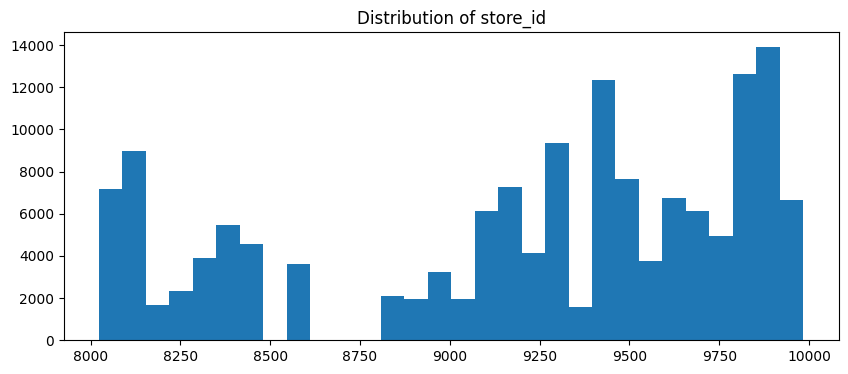

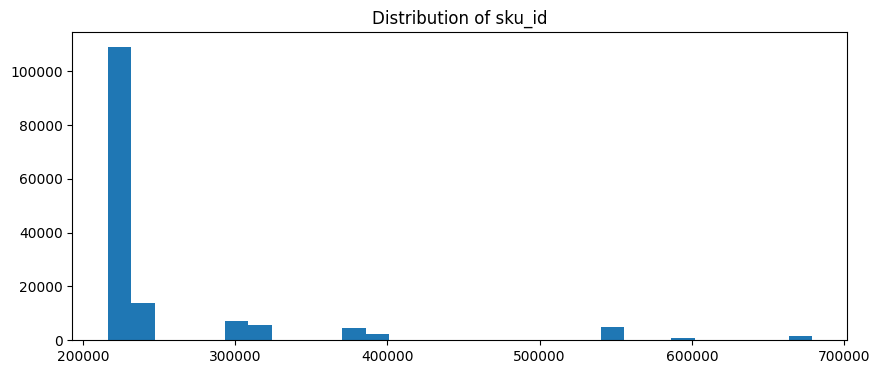

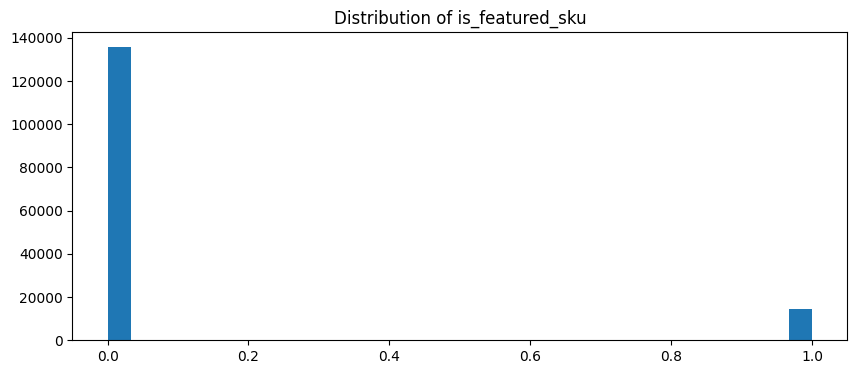

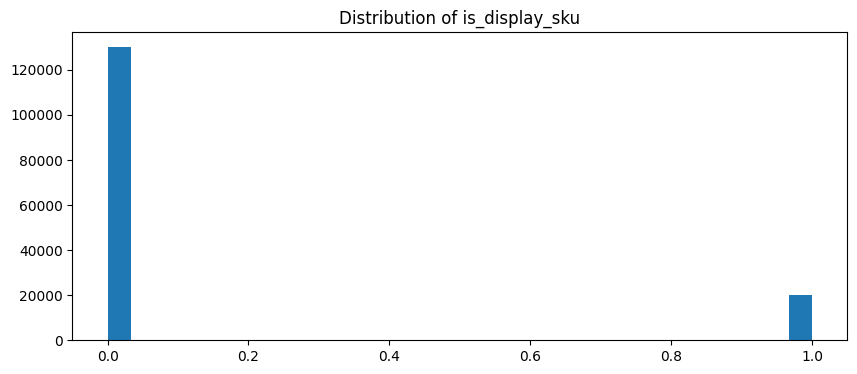

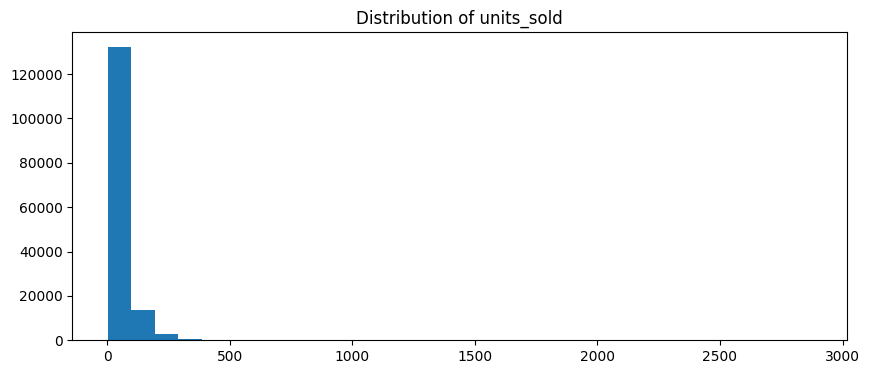

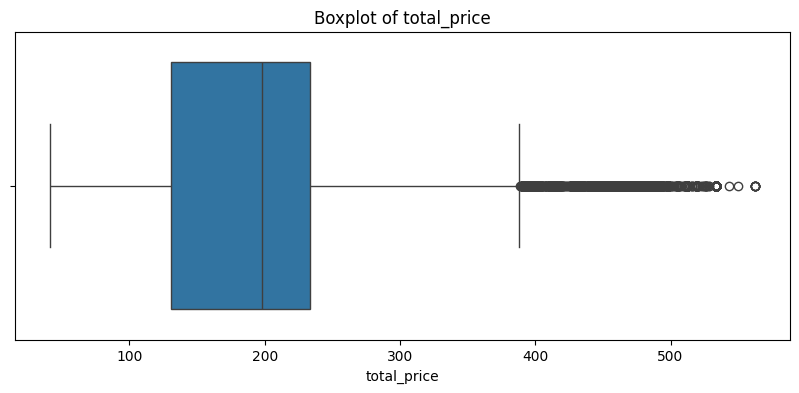

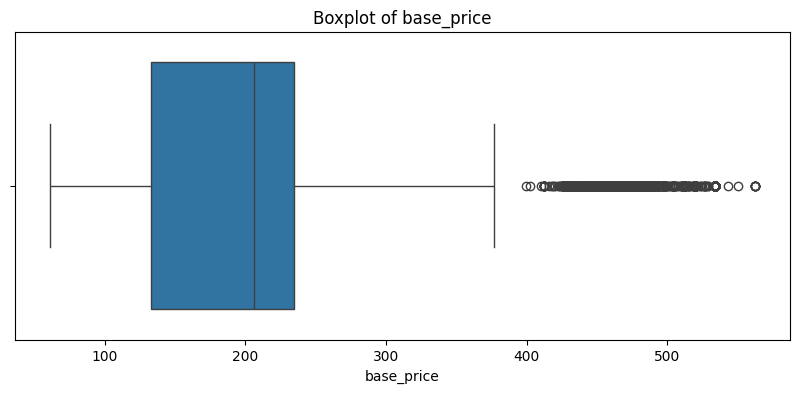

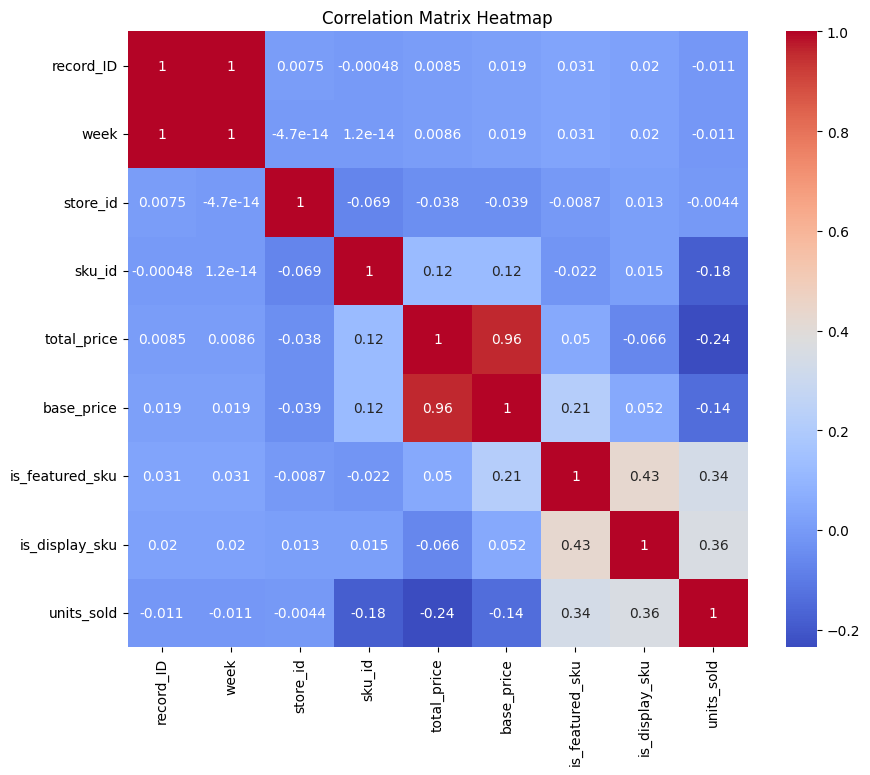

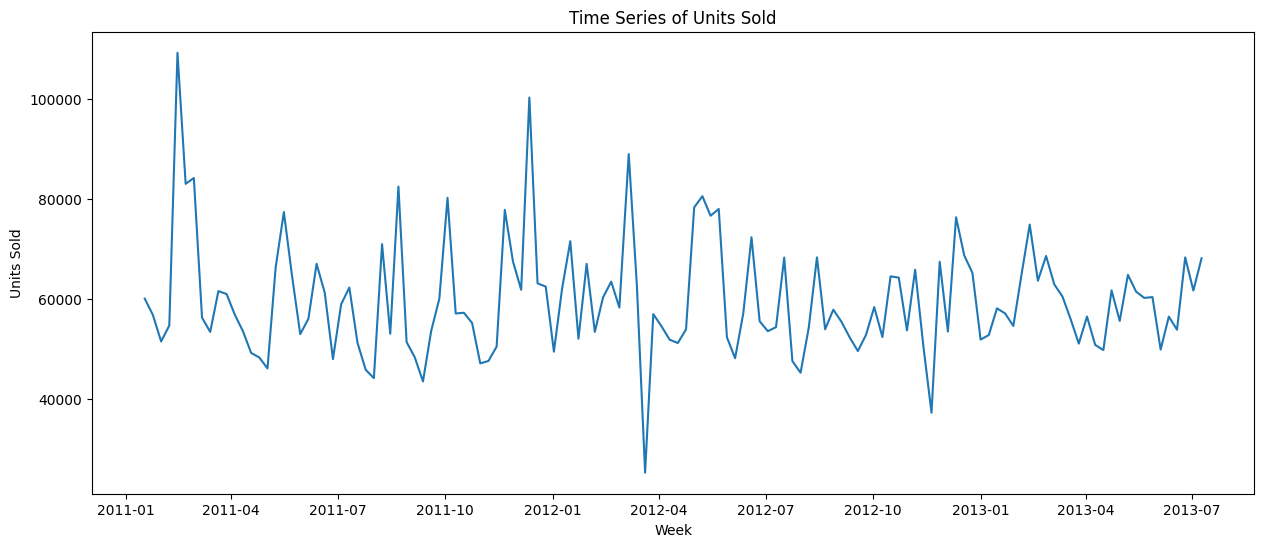

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot histograms for categorical columns and the target variable
categorical_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'units_sold']

# Plot histograms for categirocal columns and the target variable
cotegorical_cols = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku', 'units_sold']

for col in categorical_cols:
    plt.figure(figsize=(10,4))
    plt.hist(data[col], bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Boxplot for numerical columns
numerical_cols = ['total_price', 'base_price']

for col in numerical_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Check the correlation between features
correlation = data.corr() # 1 = highly correlated, -1 = negatively correlated; close to 0 = not correlated

plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Plot the time series of 'units_sold'
plt.figure(figsize=(15, 6))
plt.plot(weekly_data['week'], weekly_data['units_sold'])
plt.title('Time Series of Units Sold')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.show()

### Interpretation

units_sold: This variable, representing the number of units sold, shows a right-skewed distribution. Most of the values are low, but there are some weeks where a large number of units were sold.

total_price and base_price: These variables represent the total price and base price of the SKUs. There are some outliers, particularly for total price, which may be due to special sales or particularly expensive SKUs.

Looking at the correlation matrix, we see that is_featured_sku and is_display_sku have a moderate positive correlation with units_sold, indicating that when SKUs are featured or displayed, more units tend to be sold. There is also a slight negative correlation between total_price and units_sold, suggesting that lower priced items may sell in higher quantities.

The time series plot of units_sold shows a fairly irregular pattern with some apparent seasonality. We can see periodic spikes, which could be related to specific events or seasons throughout the year. However, there is no clear increasing or decreasing trend over the entire time period.

### Decomposition

Decompose the time series to more formally check for seasonality and trend. This involves breaking down the time series into three components:

1. Trend: The underlying pattern in the data.
2. Seasonality: Cyclical patterns in the data.
3. Residual: The remainder of the time series after the trend and seasonal components have been removed.

In [11]:
weekly_data.head()

,week,units_sold
0,2011-01-17,60029
1,2011-01-24,56752
2,2011-01-31,51467
3,2011-02-07,54656
4,2011-02-14,109207


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set 'week' as the index for the data
weekly_data.set_index('week', inplace=True)

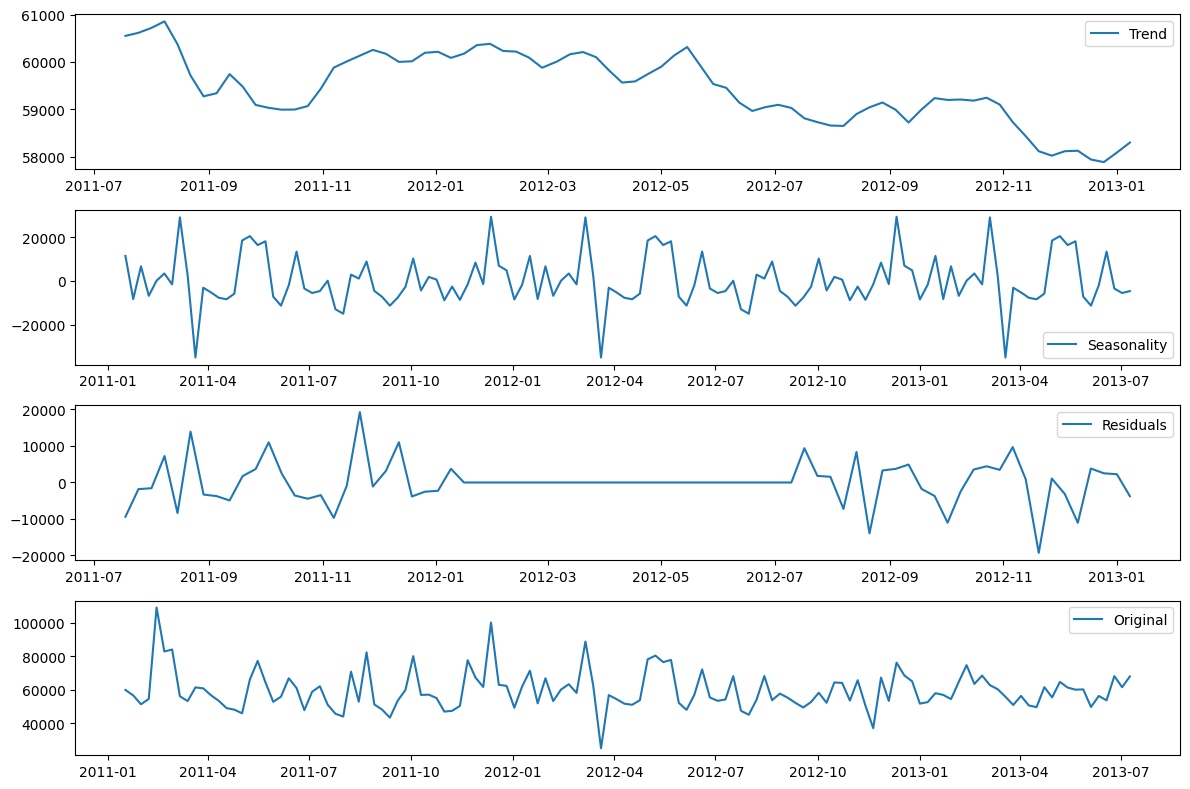

In [14]:
# Decompose the time series with a period of 52 weeks
decomposition = seasonal_decompose(weekly_data['units_sold'], period=52)

# Plot the trend, seasonality, and residuals
plt.figure(figsize=(12,8))

# Trend
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')

# Seasonality
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')

# Residuals
plt.subplot(413)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')

# Original
plt.subplot(414)
plt.plot(weekly_data['units_sold'], label='Original')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Time series decomposition reveals the following insights:

Trend: the trend components shows a relatively stable pattern over time, indicating there is no significant long-term increase or decrease in the number of units sold.

Seasonality: The seasonality component shows a clear pattern that repeats annually (ex, Jan-Apr each year shows the exact same volatility). This suggests there are specific times during the year when sales tend to be higher or lower.

Residuals: Residuals component represents the remainder of the time series after the trend and seasonal components have been removed. It shows irregular fluctuations, which could be due to random variations or other factors not captured by the trend and seasonality.

### Volatility

Measured by looking at the standard deviation of the percentage change in units_sold from one week to the next

Moving average: smooth out short-term fluctuations and highlight longer-term trends or cycles.

Calculate 4-week and 52-week moving averages (1 month and 1 year)

In [20]:
# Calculate teh percentage change in 'units_sold' from one week to the next
weekly_data['units_sold_pct_change'] = weekly_data['units_sold'].pct_change()

# Calculate the standard deviation of these percentage changes
volatility = weekly_data['units_sold_pct_change'].std()

print((volatility*100).round(2),'%')

26.06 %


Standard deviation of the percentage change in units_sold from one week to the next is approximately 26%, which means a fair amount of volatility form one week to the next.

### Moving Averages

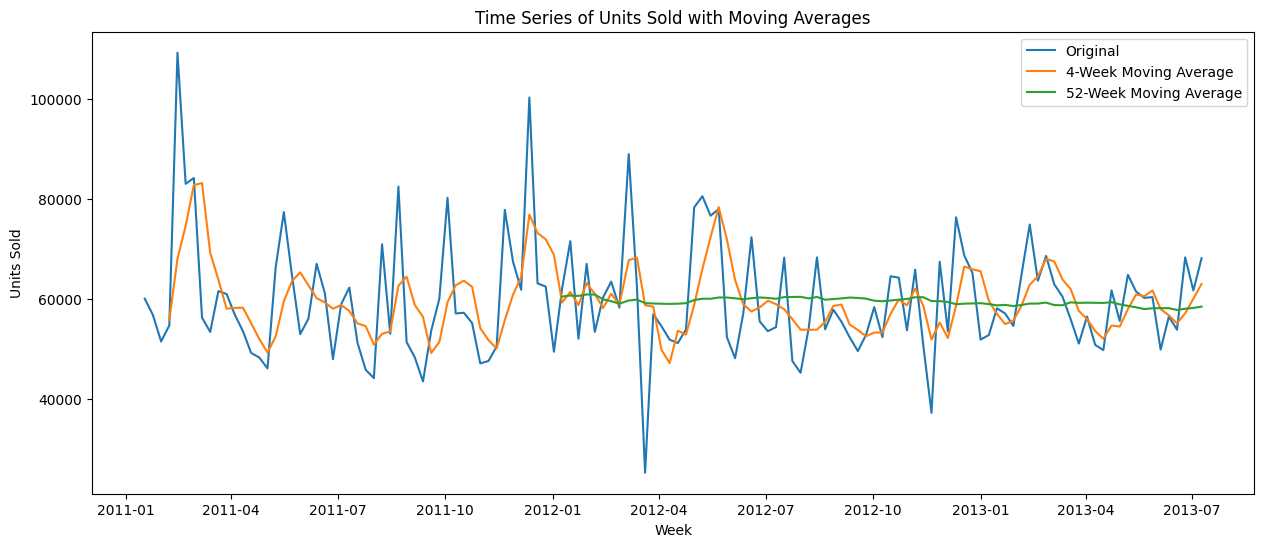

In [21]:
# Calculate the 4-week and 52-week moving averages

weekly_data['4_week_MA'] = weekly_data['units_sold'].rolling(window=4).mean()
weekly_data['52_week_MA'] = weekly_data['units_sold'].rolling(window=52).mean()

# Plot the original time series and the moving averages
plt.figure(figsize=(15, 6))

plt.plot(weekly_data['units_sold'], label='Original')
plt.plot(weekly_data['4_week_MA'], label='4-Week Moving Average')
plt.plot(weekly_data['52_week_MA'], label='52-Week Moving Average')

plt.title('Time Series of Units Sold with Moving Averages')
plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.legend()

plt.show()

The plot shows the original time series units_sold, aling with its 4-233k and 52-week moving averages. The 4-week moving average closely follows the original time series, smoothing out some of the weekly fluctuations but still capturing teh overall variability in sales. The 52-week moving average smooths out the seasonality and provides a clearer view of the long-term trend in sales. It shows a relatively stable pattern over time, which is consistent with the trend component we observed from the time series decomposition. In summary, we've conducted a comprehensive exploratory data analysis and time series analyss of the dataset.

## Autocorrelation

Autocorrlation is the measure of a time series against a lagged version of itself.

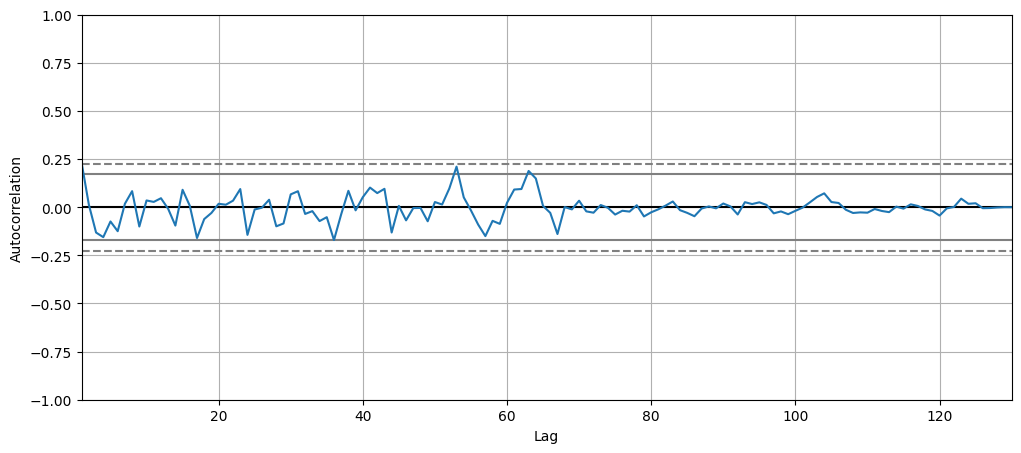

In [24]:
# First visualize autocorrelation to visually confirm/deny presence of seasonality.

from pandas.plotting import autocorrelation_plot

# Plot the autocorrelation
plt.figure(figsize=(12, 5))
autocorrelation_plot(weekly_data['units_sold'])
plt.show()

## Model fitting

Since seasonal variation doesn't increase over time, use additive version of Holt-Winters' method.